In [1]:
import csv
import polars as pl
import yfinance as yf
import pyarrow
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import linregress
import numpy as np

plt.style.use('bmh')

In [2]:
class Data_Engineering():
    def __init__(self, year):
        self.year = year
        self.value_asset_data = dict()
        self.price_data = dict()
        self.amount_data = dict()

    @staticmethod
    def to_polars(dictionary):
        """
        To convert dictionaries into polars dataframe
        """
        return pl.DataFrame(dictionary) 
    
    @staticmethod
    def _concatenate_dicts(dict1, dict2):
        """
        Hidden function which concatenates two dictionaries based on common keys, values for each key are already sorted

        Args:
        - dict1 (dict): First dictionary.
        - dict2 (dict): Second dictionary.

        Returns:
        - concatenated_dict (dict): A new dictionary with concatenated lists for matching keys.
        """

        concatenated_dict = {}
        keys = set(dict1.keys()) & set(dict2.keys()) # find the intersection of keys
        for key in keys: # for each commons keys, concatenate their values
            concatenated_dict[key] = dict1[key] + dict2[key]
        return concatenated_dict

    def value_asset_data_retriever(self, asset_line_end, asset_line_start=3, to_polars=False):
        """
        Retrieve data from a file stored in the source_files folder, whose name is in the format "YYYY.csv". Lines contains monthly value for each asset in rows, calculated at the end of each month.
        
        Args:
            asset_line_end (int): what's the last line corresponding to an asset
            asset_line_start (int, default = 3): what's the first line corresponding to an asset
            to_polars (bool, default = False): convert to polar

        """
        with open('source_files/' + str(self.year) + '.csv', mode='r') as f:
            reader = csv.reader(f)
            # Skip the first 3 lines
            for _ in range(asset_line_start):
                next(reader)

            # create a dictionary whose keys are tickers and values are the list of values in dollars for each asset, for each month
            for i, values in enumerate(reader):
                if i == asset_line_end - asset_line_start:
                    break
                self.value_asset_data[values[0]] = list(map(lambda x: int(x.replace(',', '')), values[3:15]))

        if to_polars:
            self.value_asset_data = self.to_polars(self.value_asset_data)

    def price_data_retriever(self, sampling = 'ME', to_polars=False):
        """
        Retrieve closing price data from yahoo finance for each ticker, in the given year
        
        Args:
            sampling (string, default = 'ME'): what's the frequency of data? 'ME' for monthly data
            to_polars (bool, default = False): convert to polar

        """
        tickers = list(self.value_asset_data.keys())
        for ticker in tickers:
            if ticker == "INTEL":   # to be deleted
                continue            # to be deleted
            self.price_data[ticker] = yf.Ticker(ticker).history(start = str(self.year) + '-01-01', 
                                                                end=str(self.year + 1) + '-01-01')['Close']
            if sampling == 'ME':
                self.price_data[ticker] = self.price_data[ticker].resample('ME').last().tolist()
                
        if to_polars:
            self.price_data = self.to_polars(self.price_data)

    def amount_data_calculator(self, to_polars=False):
        """
        Calculate the amount of asset each month, per each ticker
        """

        for key in self.value_asset_data:
            if key == "INTEL":      # to be deleted
                continue            # to be deleted
            self.amount_data[key] = [value / price for value, price in zip(self.value_asset_data[key], self.price_data[key])]

        if to_polars:
            self.amount_data = self.to_polars(self.amount_data)

    def get_difference(self, mode, diff=1, pct_change=False):
        """
        Calculate absolute or percentuale change in price or amount of asset per each moment
        
        Args:
            mode (string): "price" or "amount", according to the data to calculate the difference of
            diff (int, default = 1): lag
            pct_change (bool, default = False): calculate the percentuale change
        
        Returns:
            pl.Dataframe (polar dataframe)
        """
        if mode == "price":
            data = self.price_data if isinstance(self.price_data, pl.DataFrame) else self.to_polars(self.price_data)
            if pct_change:
                self.price_difference_pct = data.select([
                    pl.col(col).pct_change(diff).alias(f"{col}_{diff}_diff_pct_p") for col in data.columns
                ])
                return self.price_difference_pct
            else:
                self.price_difference = data.select([
                    pl.col(col).diff(diff).alias(f"{col}_{diff}_diff_p") for col in data.columns
                ])
                return self.price_difference

        elif mode == "amount":
            data = self.amount_data if isinstance(self.amount_data, pl.DataFrame) else self.to_polars(self.amount_data)
            self.difference_amount = data.select([
                pl.col(col).diff(diff).alias(f"{col}_{diff}_diff_q") for col in data.columns
            ])
            return self.difference_amount

    def concatenate_data(self, older):
        """
        Concatenate data from another DataEngineering instance into this one.

        Args:
        - older (InstanceClass): Another instance of DataEngineering to concatenate with.

        Returns:
        - new_instance (InstanceClass): A new instance with concatenated data.
        """
        concatenated_value_asset_data = self._concatenate_dicts(older.value_asset_data, self.value_asset_data)
        concatenated_price_data = self._concatenate_dicts(older.price_data, self.price_data)
        concatenated_amount_data = self._concatenate_dicts(older.amount_data, self.amount_data)
        
        # Create a new instance with default year and updated data
        new_instance = Data_Engineering(year = self.year)
        new_instance.value_asset_data = concatenated_value_asset_data
        new_instance.price_data = concatenated_price_data
        new_instance.amount_data = concatenated_amount_data
        return new_instance

data_2023 = Data_Engineering(2023)
data_2023.value_asset_data_retriever(13)
data_2023.price_data_retriever()
data_2023.amount_data_calculator()

data_2022 = Data_Engineering(2022)
data_2022.value_asset_data_retriever(16)
data_2022.price_data_retriever()
data_2022.amount_data_calculator()

# Concatenate data

data_2022_2023 = data_2023.concatenate_data(data_2022)

In [3]:
prices = pd.DataFrame(data_2022_2023.price_data)

quantity = pd.DataFrame(data_2022_2023.amount_data)
quantity_change = data_2022_2023.get_difference("amount", diff = 1, pct_change= False).to_pandas()

value = pd.DataFrame(data_2022_2023.value_asset_data)

# Exploratory Data Analysis

## Focus on Value

### Portfolio perspecive
* All'inizio dell'analisi, a gennaio 2022, il portafoglio in oggetto raggiungeva un valore di circa 750'694€.
* Il valore del portafoglio ha goduto di un trend positivo negli anni in oggetto, con un valore al termine dell'analisi di 939'886€; con una crescita mensile media del valore del portafogli di 10440€ e una variazione nell'intero periodo del 25.20%.
* Il minimo globale è stato raggiunto nel giugno 2022, di circa 657'995€, con un drawdown del -12% dai massimi precedenti.
* Lo stesso mese è stato raggiunto il massimo drawdown mensile dell'intero periodo, pari al -9.45%.
* Un ulteriore importante drawdown è stato registrato ad ottobre 2023, pari al -8.77%.
* L'oscillazione positiva massima è stata raggiunta a novembre 2022, pari al  +8.30%-
* Il ritorno medio mensile è pari al +1.10%, mentre la deviazione standard dei rendimenti mensili è pari al 5.04%

In [4]:
def subplotting_dataframe(dataframe):
    """
        Plotting each column in a dataframe using subplots

        Parameters: 
        dataframe (pd.DataFrame)
    """
    num_columns = len(dataframe.columns)
    fig, axs = plt.subplots(num_columns, 1, figsize=(8, 2 * num_columns))
    plt.gcf().set_dpi(150)

    # Plot each column in a separate subplot
    for i, column in enumerate(dataframe.columns):
        axs[i].plot(dataframe.index, dataframe[column])
        axs[i].set_title(f'{column}')
        axs[i].grid(True)

    plt.axhline(y = 0, color = 'black', alpha = 0.5, linewidth = 1)
    plt.tight_layout()
    plt.show()

In [5]:
def generate_analysis_report(df):
    """Generate the analysis report"""
    
    # Set the heading
    print(f"\n{'='*50}")
    print(f"{'Analysis Report for ' + df.columns.name:^50}")
    print(f"{'='*50}\n")

    print(f"First period value: {df['abs'][0]:,}")
    print(f"Last period value: {df['abs'][23]:,}")
    print(f"Average monthly variability: {int(linregress(df['abs'].index, df['abs'])[0]):,}")
    
    total_variation = (df['abs'][23] - df['abs'][0]) / df['abs'][0] * 100
    print(f"Total variation: {total_variation:.2f}%")
    print(f"Minimum of {df['abs'].min():,} reached at month {df['abs'].idxmin() + 1}")
    print(f"Maximum of {df['abs'].max():,} reached at month {df['abs'].idxmax() + 1}")
    print(f"Mean of Asset Value: {df['abs'].mean():,.2f}")
    print(f"Standard Deviation of Asset Value: {df['abs'].std():,.2f}")
    print(f"Correlation coefficient: {df['abs'].std() / df['abs'].mean()}\n")

    print(f"{'-'*50}")
    print(f"{'Return Analysis':^50}")
    print(f"{'-'*50}\n")
    
    print(f"Minimum return: {df['pct_change'].min():.2f}% reached at month {df['pct_change'].idxmin() + 1}")
    print(f"Maximum return: {df['pct_change'].max():.2f}% reached at month {df['pct_change'].idxmax() + 1}")
    print(f"Mean of monthly returns: {df['pct_change'].mean():.2f}%")
    print(f"Standard Deviation of monthly returns: {df['pct_change'].std():.2f}%")
    print(f"Correlation coefficient: {df['pct_change'].std() / df['pct_change'].mean()}\n")

In [97]:
def generate_monthly_portfolio(df, type, axisname):
    if type == 'df':
        monthly_value_portfolio = pd.DataFrame([df.sum(axis =1), df.sum(axis = 1).pct_change() * 100]).T
        monthly_value_portfolio.rename(columns = {0:"abs", 1:"pct_change"}, inplace = True)
    elif type == 'series':
        monthly_value_portfolio = pd.DataFrame({"abs": df, "pct_change": df.pct_change() * 100})
        monthly_value_portfolio.set_axis(["abs", "pct_change"], axis = 1)
        
    monthly_value_portfolio.rename_axis(axisname, axis = 1, inplace = True)
    monthly_value_portfolio.fillna(monthly_value_portfolio['pct_change'].median(), inplace = True)
    
    return monthly_value_portfolio

In [98]:
monthly_value_portfolio = generate_monthly_portfolio(value, 'df', 'Portfolio')
monthly_value_portfolio.head()

Portfolio,abs,pct_change
0,750694.0,1.734286
1,740175.0,-1.401237
2,754823.0,1.978991
3,714242.0,-5.376227
4,726629.0,1.734286


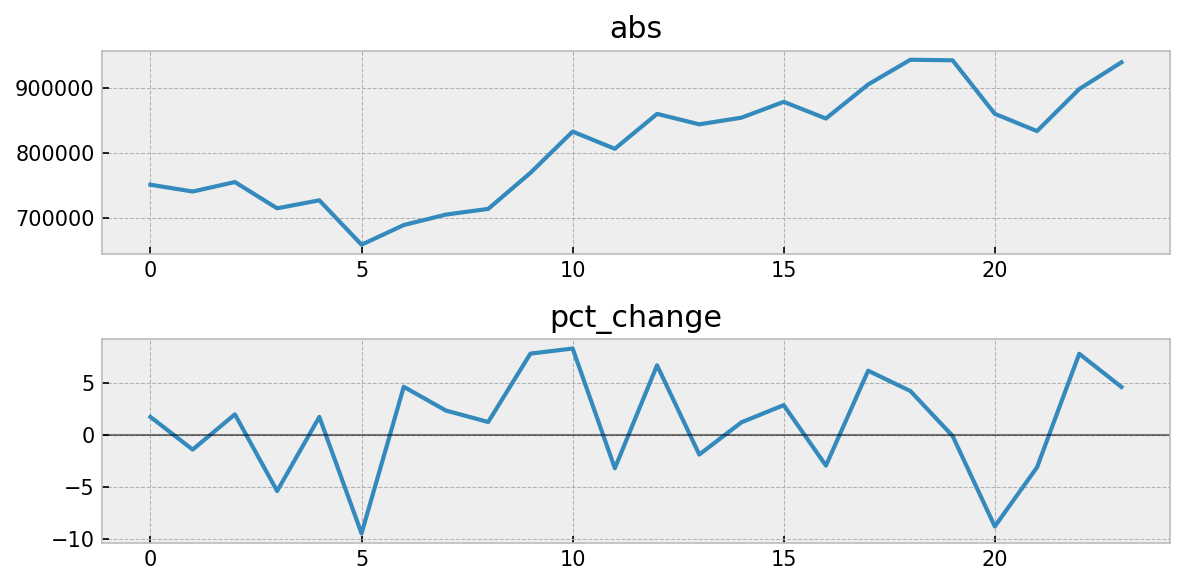

In [99]:
subplotting_dataframe(monthly_value_portfolio)

In [100]:
generate_analysis_report(monthly_value_portfolio)


          Analysis Report for Portfolio           

First period value: 750,694.0
Last period value: 939,886.0
Average monthly variability: 10,440
Total variation: 25.20%
Minimum of 657,995.0 reached at month 6
Maximum of 943,813.0 reached at month 19
Mean of Asset Value: 811,406.71
Standard Deviation of Asset Value: 86,680.39
Correlation coefficient: 0.1068273081779971

--------------------------------------------------
                 Return Analysis                  
--------------------------------------------------

Minimum return: -9.45% reached at month 6
Maximum return: 8.30% reached at month 11
Mean of monthly returns: 1.13%
Standard Deviation of monthly returns: 4.93%
Correlation coefficient: 4.359393579044397



## Focus on Value

### Single asset perspective * da sistemare *
- Tutti gli ETF hanno accresciuto il proprio valore, . Questo può essere determinato dall'effetto dell'aumento di prezzo dello strumento e dall'effetto dell'aumento del numero di asset detenuti ogni mese. 


In [102]:
for col in value.columns:
    lookup = generate_monthly_portfolio(value[col], 'series', col)
    print(lookup)
    generate_analysis_report(lookup)

VBR    abs  pct_change
0    68384   -0.957420
1    69496    1.626111
2    70376    1.266260
3    65916   -6.337388
4    67144    1.862977
5    59928  -10.747051
6    65816    9.825123
7    64008   -2.747052
8    57360  -10.386202
9    64244   12.001395
10   67816    5.560052
11   63520   -6.334788
12   69284    9.074307
13   67720   -2.257375
14   63504   -6.225635
15   62896   -0.957420
16   60744   -3.421521
17   66160    8.916107
18   69756    5.435308
19   67380   -3.406159
20   63796   -5.319086
21   60708   -4.840429
22   65964    8.657838
23   71988    9.132254

             Analysis Report for VBR              

First period value: 68,384
Last period value: 71,988
Average monthly variability: -28
Total variation: 5.27%
Minimum of 57,360 reached at month 9
Maximum of 71,988 reached at month 24
Mean of Asset Value: 65,579.50
Standard Deviation of Asset Value: 3,636.59
Correlation coefficient: 0.055453209977581894

--------------------------------------------------
               

/tmp/ipykernel_18777/1279096621.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  total_variation = (df['abs'][23] - df['abs'][0]) / df['abs'][0] * 100
/home/vincenzopi/Scrivania/MrRipStrategyAnalysis_venv/MrRipStrategyAnalysis_venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


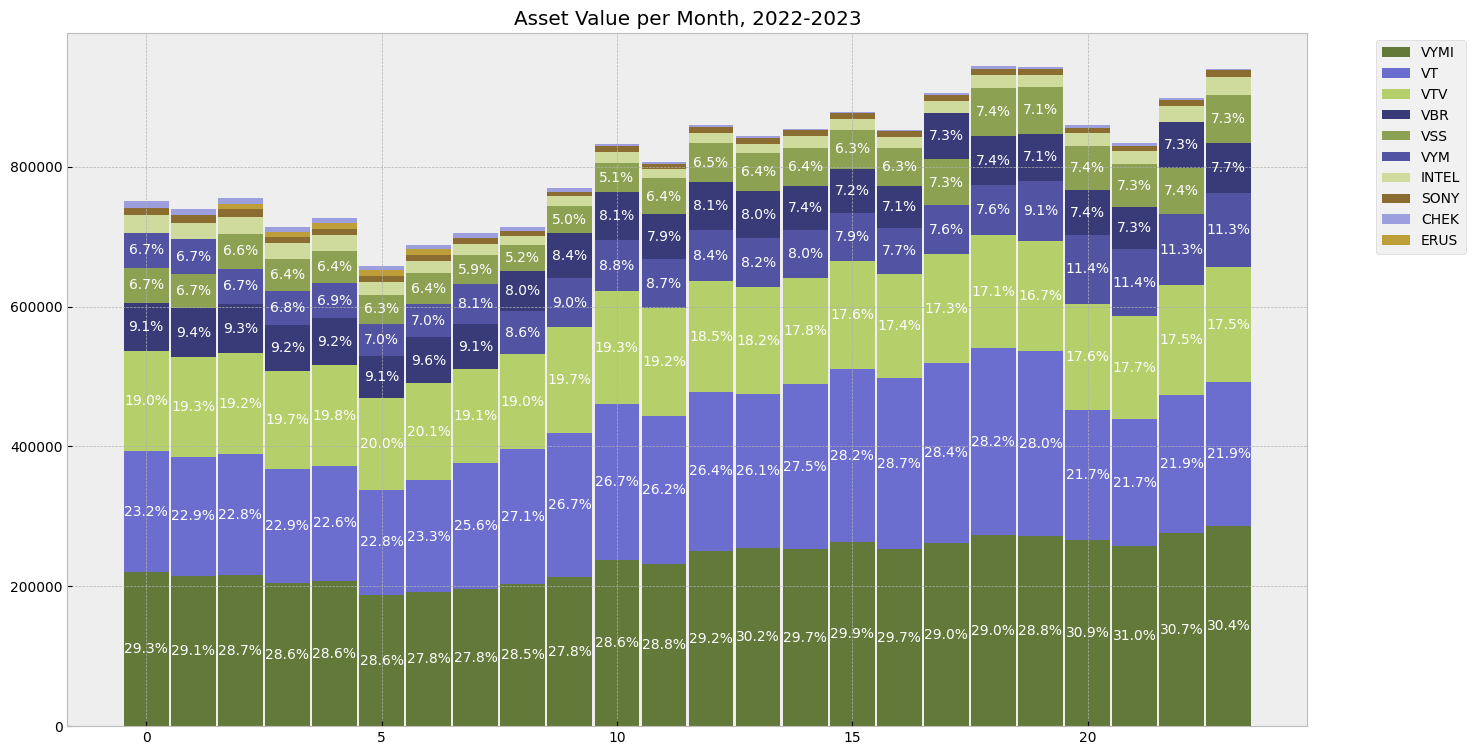

In [103]:
fig, ax = plt.subplots(figsize = (16, 9))

# Get x-axis labels from the DataFrame's index
x = value.index

# Sorting indexes and values as before
indexes = np.argsort(value.values).T
widths = np.sort(value.values).T
order = -1
lefts = widths[::order].cumsum(axis=0)
lefts = np.insert(lefts, 0, np.zeros(len(lefts[0])), axis=0)

# Use the tab20b colormap
mpp_colors = dict(zip(value.columns, plt.colormaps.get_cmap("tab20b").colors))

# Create the stacked bar chart
for k, (idxs, vals) in enumerate(list(zip(indexes, widths))[::order]):
    mps = np.take(np.array(value.columns), idxs)
    bars = ax.bar(x, height=vals, bottom=lefts[k], color=[mpp_colors[m] for m in mps], width = 0.95)

    # Adding percentage labels for each segment
    for i, (bar, val) in enumerate(zip(bars, vals)):
        # Calculate the total value for the current row (category)
        total = value.iloc[i].sum()
        percentage = (val / total) * 100
        
        # Only display percentages above a threshold (optional, set to 0% here)
        if percentage > 5:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # x-coordinate (center of the bar)
                lefts[k][i] + val / 2,  # y-coordinate (center of the segment)
                f'{percentage:.1f}%',  # Percentage text
                ha='center', va='center', fontsize=10, color='white'
            )

# Add legend
ax.legend((np.take(np.array(value.columns), np.argsort(value.values)[0]))[::-1], 
          bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
ax.set_title('Asset Value per Month, 2022-2023')


plt.show()

In [ ]:
monthly_value_pct = value.div(value.sum(axis=1), axis=0)*100
monthly_value_pct.describe()

,SONY,ERUS,CHEK,VSS,VTV,VBR,VT,VYMI,VYM,INTEL
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,1.085740,0.240911,0.594302,6.504742,18.522299,8.158055,25.056528,29.198240,8.373617,2.265566
std,0.169735,0.471941,0.369684,0.693834,1.051065,0.863745,2.531162,0.943496,1.565334,0.586991
min,0.877369,0.000000,0.154760,5.004395,16.740794,7.121203,21.663067,27.783241,6.680312,1.476868
25%,0.982189,0.004443,0.314008,6.304148,17.580526,7.378548,22.799745,28.611292,6.954865,1.833759
50%,1.013928,0.004714,0.416471,6.419954,18.734468,8.032374,25.813565,28.982423,8.063922,1.989140
75%,1.213677,0.005625,0.954412,7.137763,19.311187,9.108110,27.191061,29.778202,8.873557,2.715579
max,1.487424,1.224933,1.335090,7.407011,20.125941,9.560512,28.665349,30.966574,11.448068,3.282889


## Focus on Quantity * da sistemare *

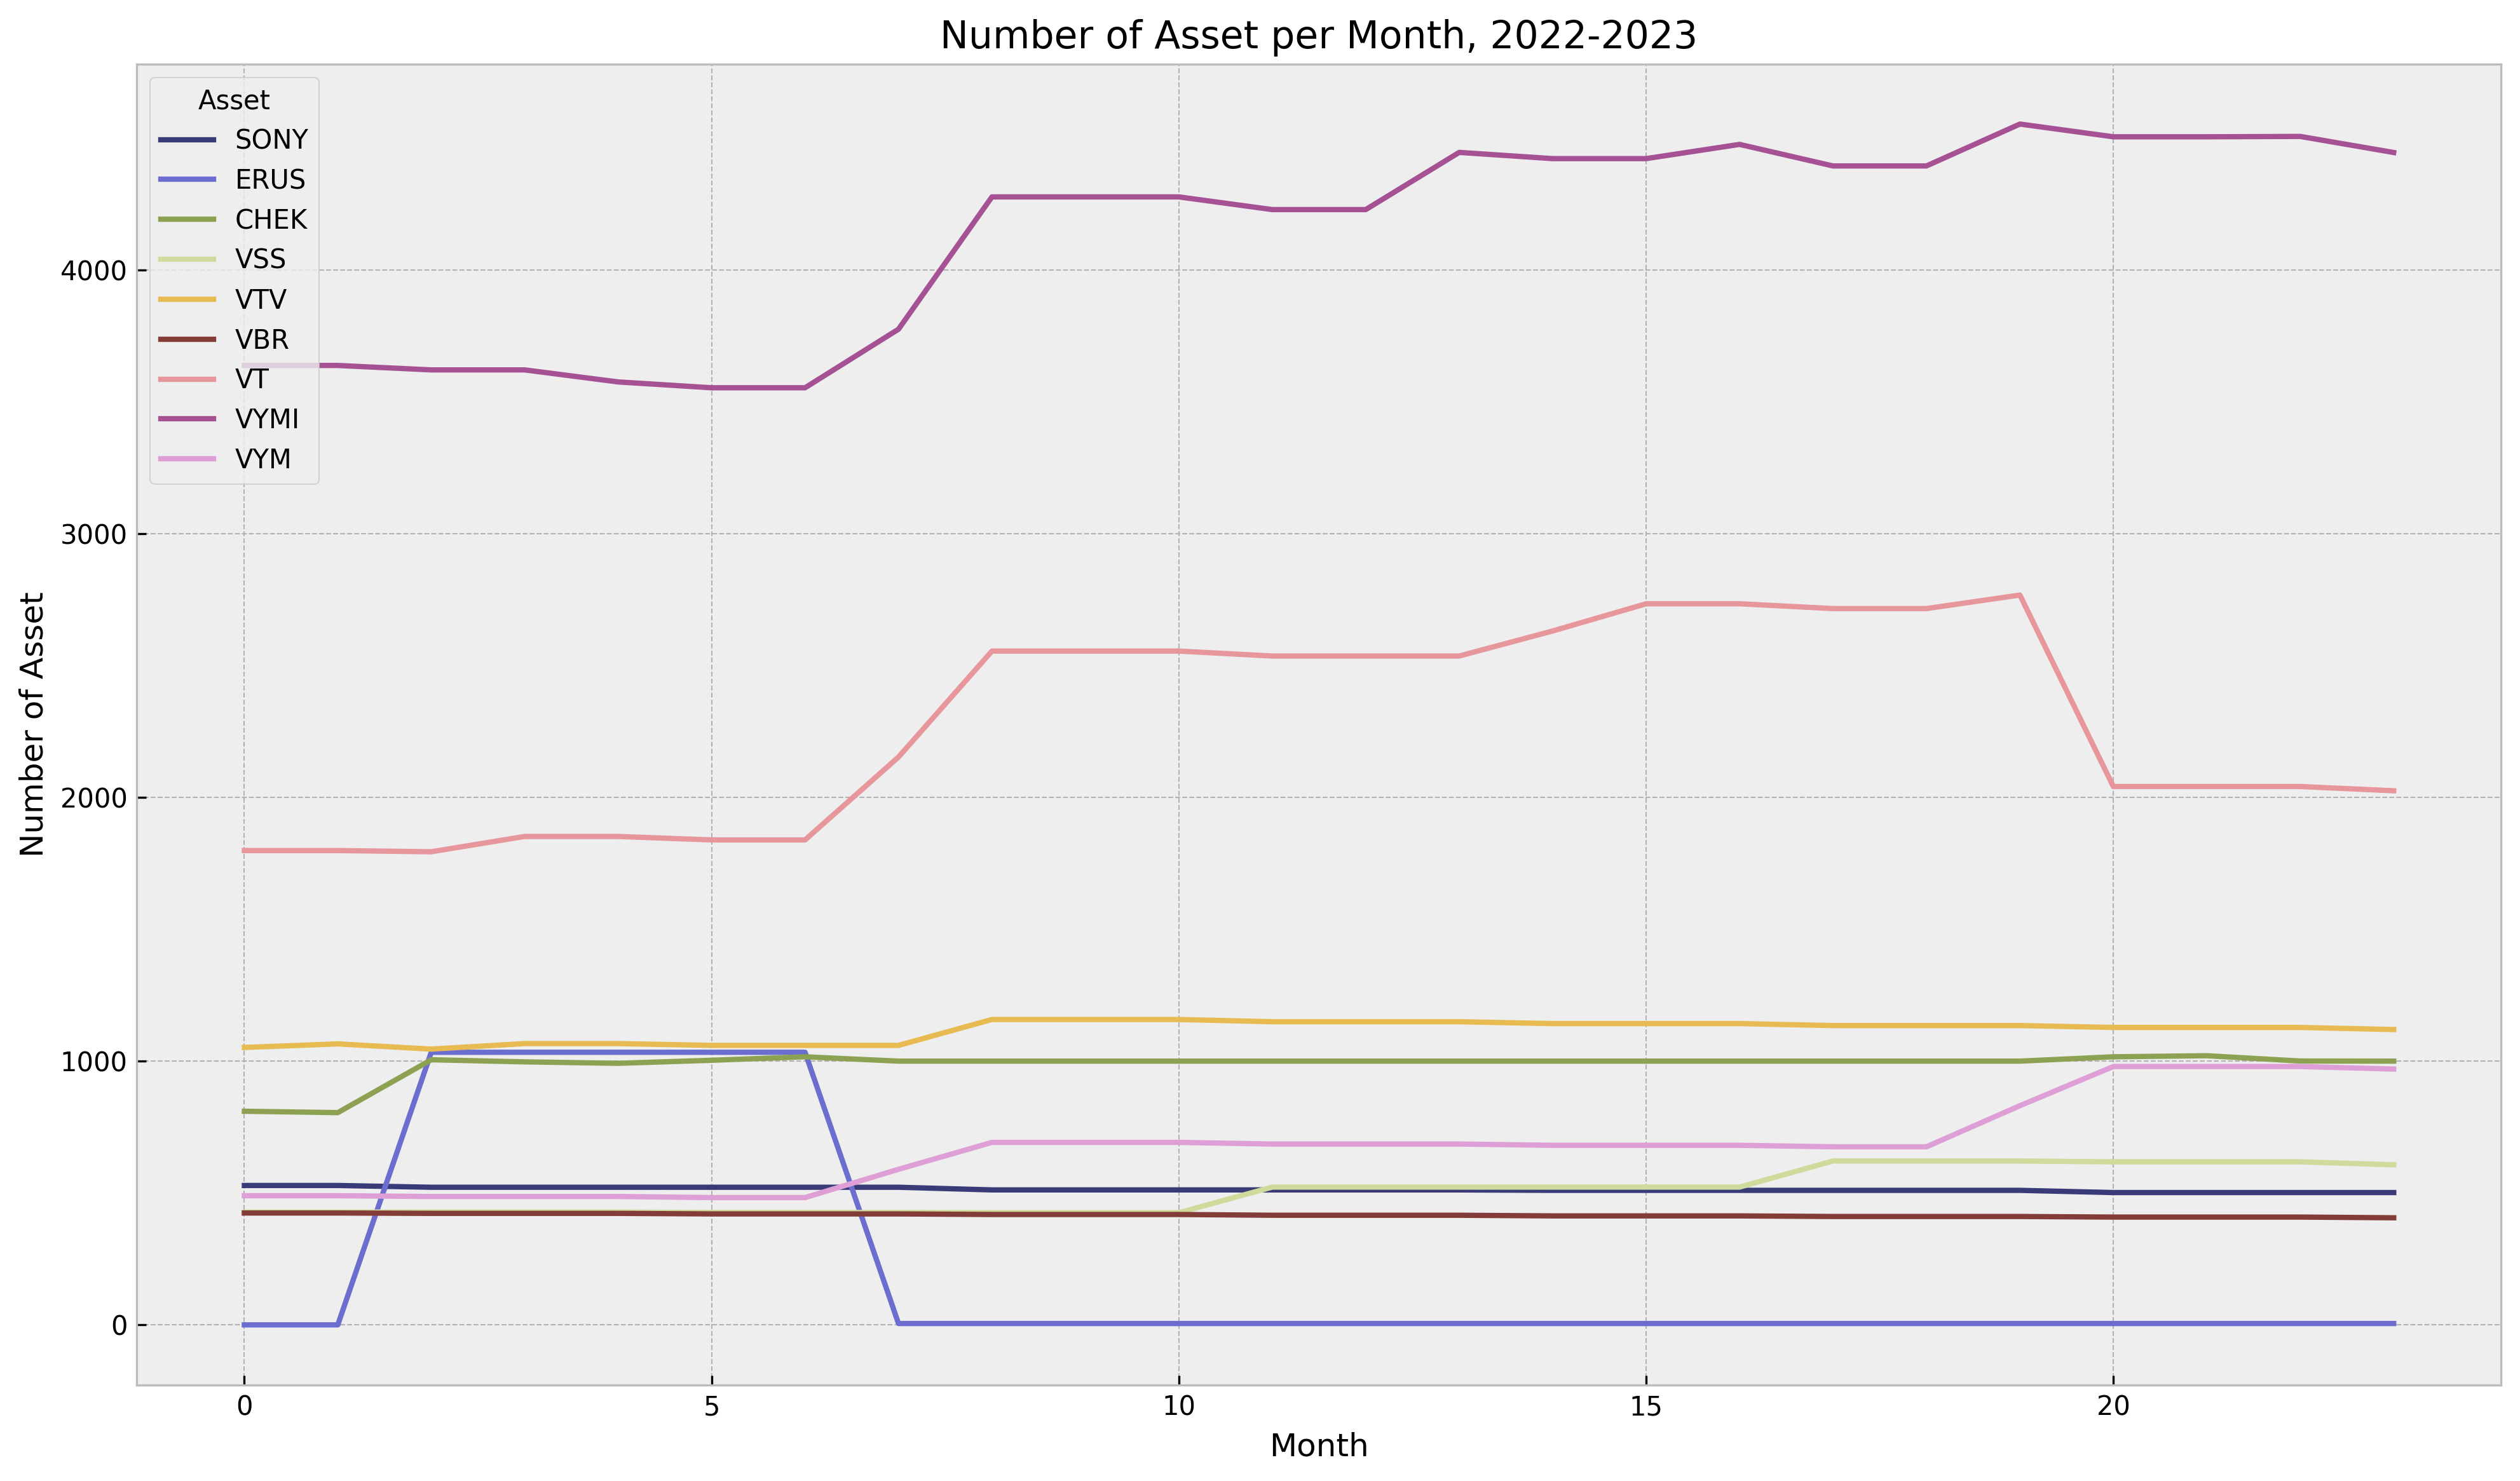

In [ ]:
quantity.plot(kind = 'line', figsize=(16,9), colormap = 'tab20b')
plt.gcf().set_dpi(300)
plt.xlabel('Month')
plt.ylabel('Number of Asset')
plt.title('Number of Asset per Month, 2022-2023')
plt.legend(title='Asset', loc='upper left')
plt.show()

Ad una prima ispezione visiva sulla quantità di ciascun asset detenuto alla fine di ogni mese si nota che: 
- Per la maggior parte degli asset, la quantità detenuta nel tempo è stabile o crescente, in linea con l'approccio "buy and hold" più volte richiamato da MrRIP
- VYMI e VT, che componon

In [ ]:
quantity.head()

,CHEK,VTV,VBR,VT,VYMI,ERUS,SONY,VSS,VYM
0,810.000027,1051.854051,424.193917,1798.479789,3637.777757,0.000000,521.863666,427.594566,489.636627
1,804.723145,1065.330835,424.193872,1798.479731,3637.777775,0.000000,521.863647,427.594542,489.636628
2,1005.154610,1045.657714,422.698977,1793.889221,3620.982795,1033.570885,520.537052,427.594546,486.752200
3,997.229946,1066.514424,422.699047,1851.927279,3620.983258,1033.570885,520.537108,427.594560,486.752426
4,991.735506,1066.514584,422.698936,1851.923650,3575.329015,1033.570885,520.537057,427.594594,486.752277


## Focus on purchasing strategy each month

In [ ]:
quantity_change.head()

,SONY_1_diff_q,VYMI_1_diff_q,ERUS_1_diff_q,VYM_1_diff_q,VTV_1_diff_q,VSS_1_diff_q,CHEK_1_diff_q,VT_1_diff_q,VBR_1_diff_q
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.000066,0.000482,0.000000,-0.000073,13.477023,0.000032,-5.276883,-0.000341,-0.000005
2,-1.347451,-16.795215,1033.570885,-2.884318,-19.673357,-0.000024,200.431465,-4.590653,-1.494973
3,0.000002,0.000218,0.000000,0.000227,20.856949,-0.000017,-7.924664,58.038200,0.000067
4,-0.000002,-45.654702,0.000000,-0.000187,0.000037,0.000035,-5.494440,-0.003470,-0.000029


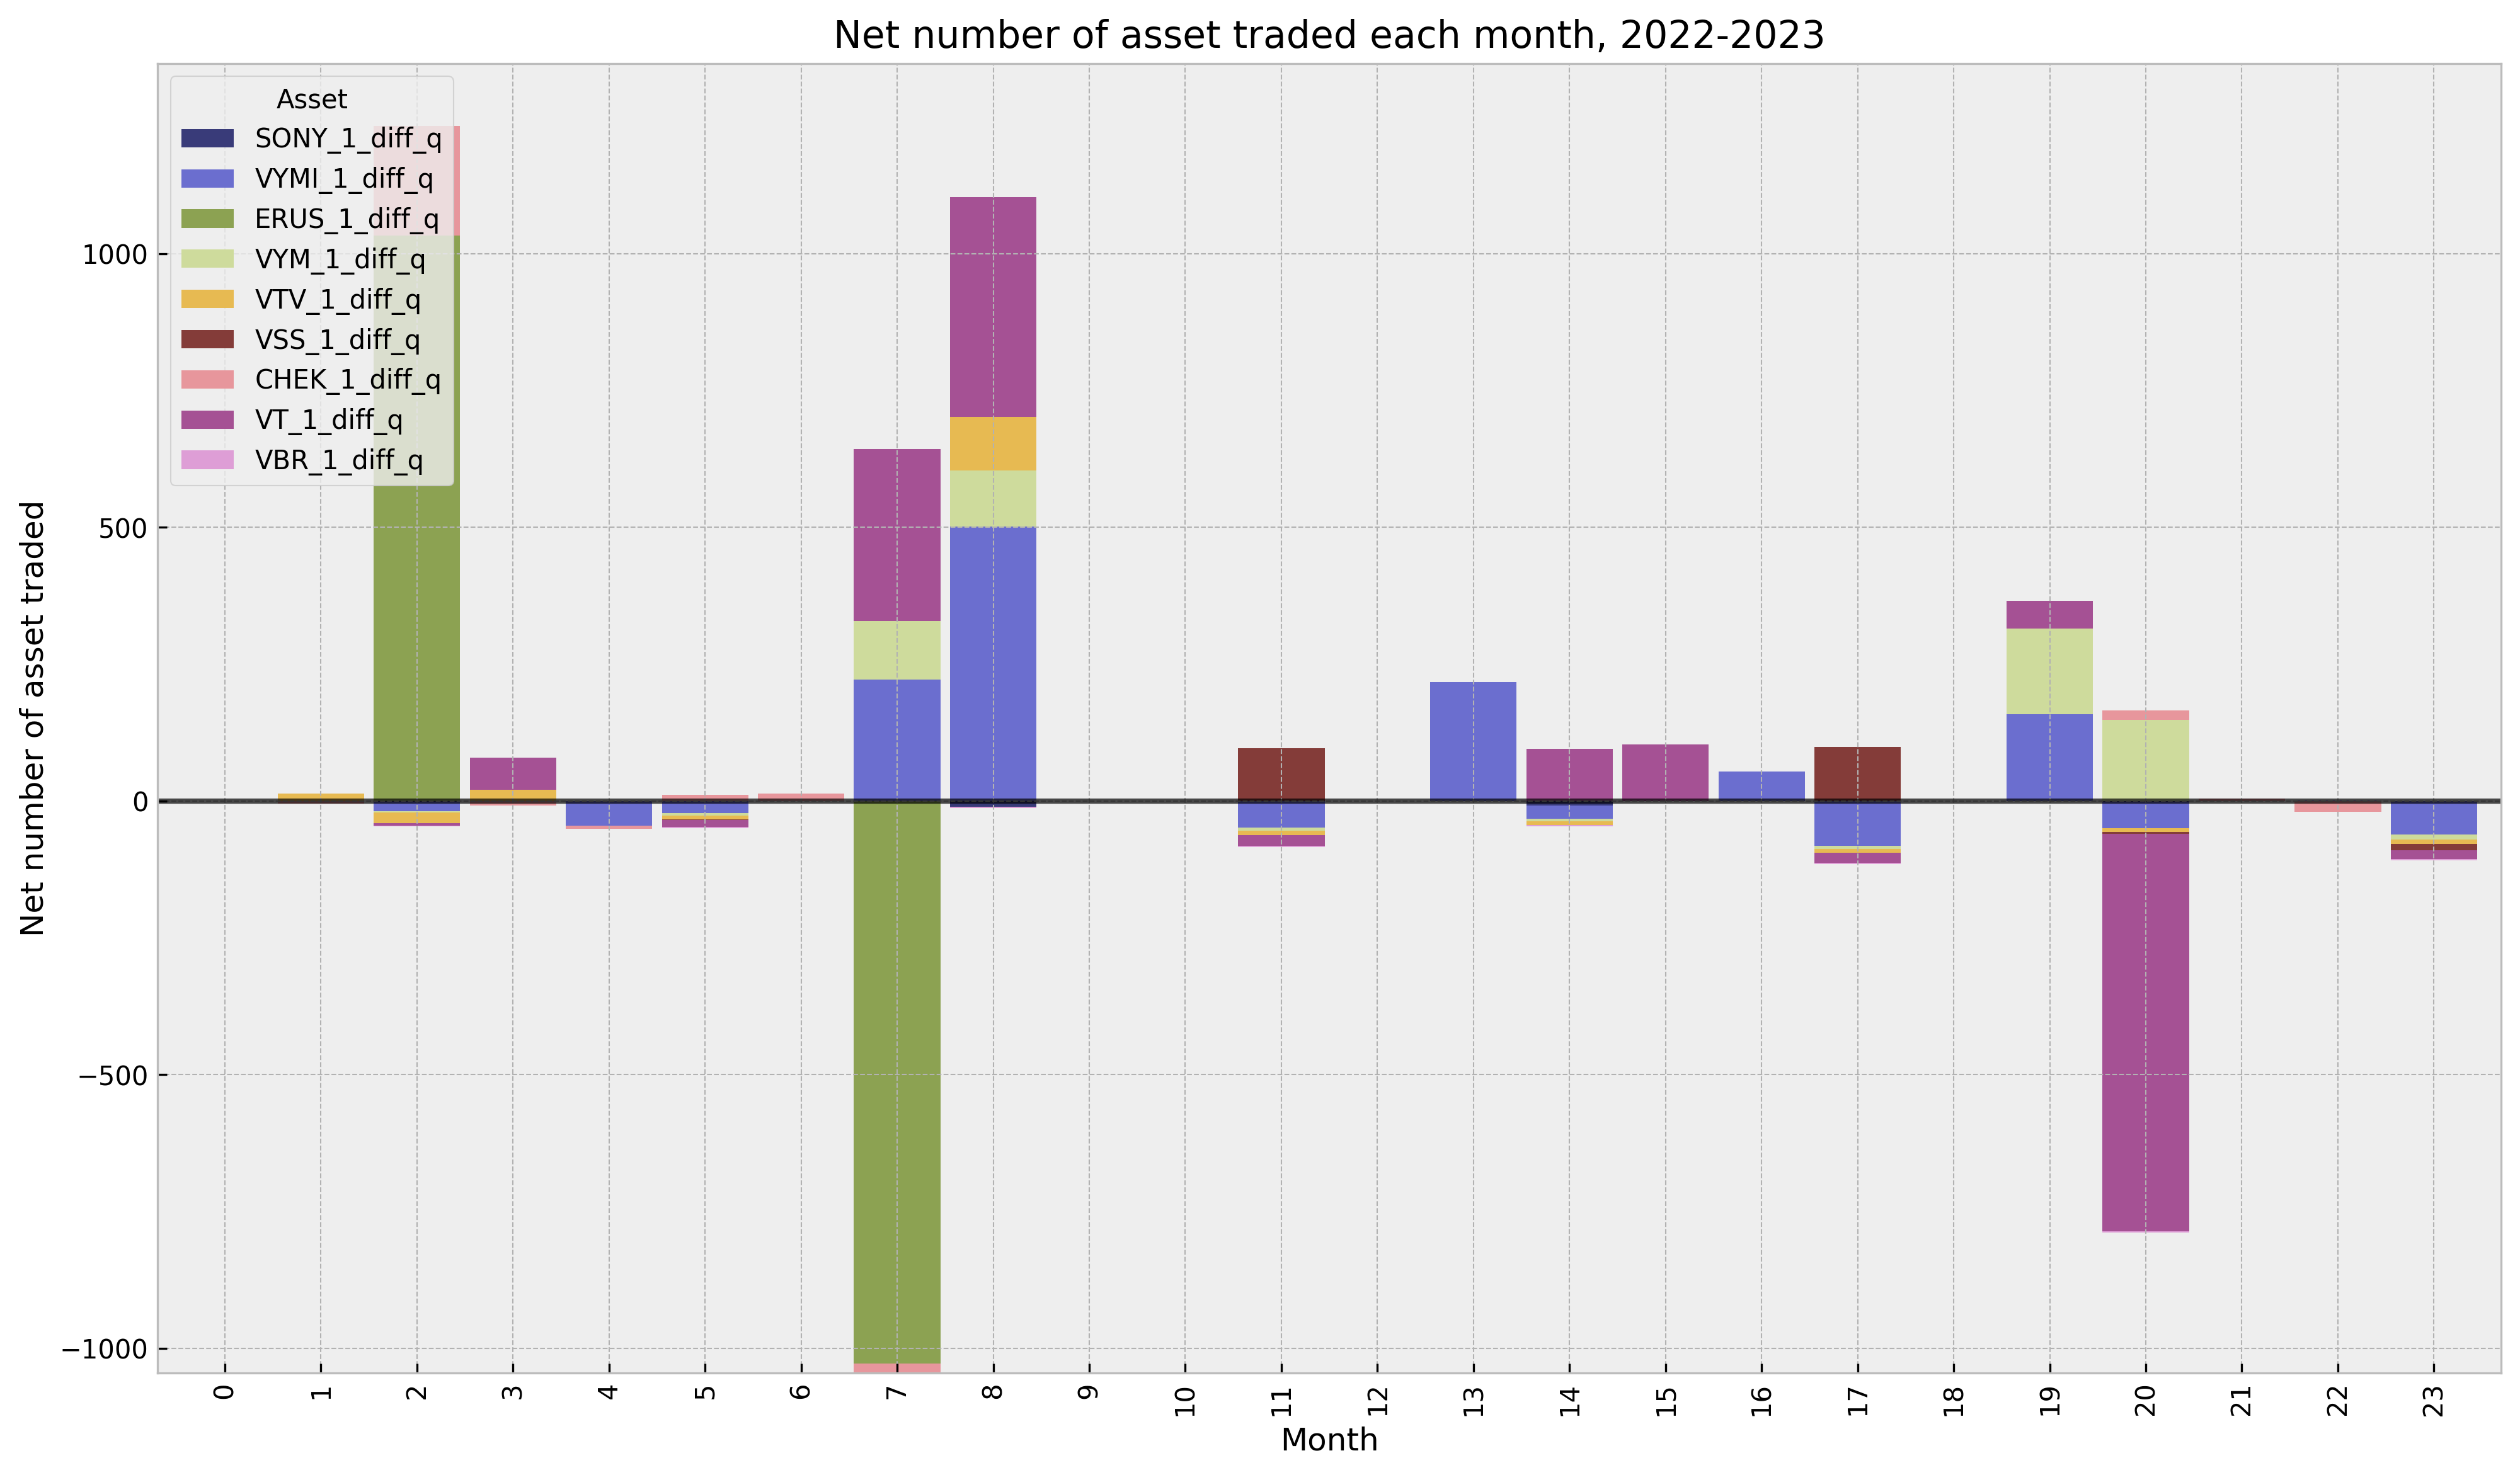

In [ ]:
quantity_change.plot(kind = 'bar', figsize = (16,9), stacked = True, width = 0.9, colormap = 'tab20b')
plt.gcf().set_dpi(300)
plt.xlabel('Month')
plt.ylabel('Net number of asset traded')
plt.title('Net number of asset traded each month, 2022-2023')
plt.legend(title='Asset', loc='upper left')
plt.axhline(y = 0, color = 'black', alpha = 0.7)
plt.show()

# Detecting statistically significant correlations in asset purchasing
Given:
* a set of asset $A_{n}$,
* their quantity bought each month $Quantity_{A, t}$,
* their monthly price $Price_{A, t}$

For each asset $A$ is calculated the pearson correlation between its Quantity and Quantities and Prices of any other asset, at different time lags, as well.
The variables significantly correlated will be returned, and their correlation coefficients.

In [ ]:
def add_suffix_and_combine_dfs(dfs, suffixes):  
    """
    Combine dataframes and add suffixes in case they share the same columns
    Parameters:
    dfs (list of pd.DataFrame) : A list containing the dataframes to be concatenated
    suffixes (list of strings) : A list containing the suffixes to be added to each dataframe. REMEMBER: also '' can be used

    Returns:
    combined_df (pd.DataFrame) : The dataframe combined
    """
    modified_dfs = []
    
    for df, suffix in zip(dfs, suffixes):
        # Add suffix to column names
        df.columns = [f"{col}{suffix}" for col in df.columns]
        modified_dfs.append(df)
    
    # Combine DataFrames horizontally
    combined_df = pd.concat(modified_dfs, axis=1)
    
    return combined_df


In [ ]:
def calculate_correlation(dataframe):
    """
    Calculate correlations among each pair of columns and display only the significant ones.
    
    Parameters:
    dataframe (pd.DataFrame): The DataFrame to calculate correlations for.
    
    Returns:
    dict: A dictionary with significant correlations.
    """
    
    columns = dataframe.columns
    correlations = {}
    
    for i, column_a in enumerate(columns):
        for column_b in columns[i + 1:]:  # Ensure we only compare each pair once
            # Check if both columns end with 'p'
            if column_a.endswith('p') and column_b.endswith('p'):
                continue
            
            # Calculate Pearson correlation and p-value
            corr, p_value = pearsonr(dataframe[column_a], dataframe[column_b])
            
            # Record significant correlations
            if p_value <= 0.05:
                correlations[f"{column_a} vs. {column_b}"] = float(corr)

    return correlations

In [ ]:
price_change_1 = data_2022_2023.get_difference('price', diff = 1, pct_change = False).to_pandas()
price_change_2 = data_2022_2023.get_difference('price', diff = 2, pct_change = False).to_pandas()
price_change_3 = data_2022_2023.get_difference('price', diff = 3, pct_change = False).to_pandas()

correlation_dataframe = add_suffix_and_combine_dfs([quantity, quantity_change, prices, price_change_1, price_change_2, price_change_3], ['q', '', 'p', '', '', '']).dropna()

calculate_correlation(correlation_dataframe)

{'SONYqq vs. VYMIqq': -0.937961462749461,
 'SONYqq vs. ERUSqq': 0.7520517802410381,
 'SONYqq vs. VYMqq': -0.8158174844765923,
 'SONYqq vs. VTVqq': -0.6991075461399506,
 'SONYqq vs. VSSqq': -0.8546264218944757,
 'SONYqq vs. VTqq': -0.507047110432648,
 'SONYqq vs. VBRqq': 0.9389005398723452,
 'SONYqq vs. VYMIpp': -0.577668294971433,
 'SONYqq vs. ERUSpp': -0.7520517802410382,
 'SONYqq vs. VTVpp': -0.477017957432457,
 'SONYqq vs. CHEKpp': 0.8336387923985462,
 'SONYqq vs. VTpp': -0.5932908007220038,
 'SONYqq vs. SONY_3_diff_p': -0.4588925938138858,
 'SONYqq vs. ERUS_3_diff_p': -0.44229673513537565,
 'SONYqq vs. VSS_3_diff_p': -0.4495705439929174,
 'SONYqq vs. CHEK_3_diff_p': -0.5385761548703488,
 'SONYqq vs. VT_3_diff_p': -0.5284019033221098,
 'VYMIqq vs. ERUSqq': -0.887354771882542,
 'VYMIqq vs. VYMqq': 0.7997776001440109,
 'VYMIqq vs. VTVqq': 0.8580244987062012,
 'VYMIqq vs. VSSqq': 0.7454553879045024,
 'VYMIqq vs. VTqq': 0.648288800033528,
 'VYMIqq vs. VBRqq': -0.8410548172189214,
 'VYMI

# Detecting purchasing strategy: focusing on the amount of stocks owned each month of the same asset using a time-series approach
Given:
* an the array of the number of units, for each month $A_{t}$,

For each asset $A$, using time-series analysis, discovering any statistically significant association between $Quantity_{A, t}$ at any given time and $Quantity_{A, t-n}$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

In [ ]:
def subplotting_dataframe(dataframe):
    """
        Plotting each column in a dataframe using subplots

        Parameters: 
        dataframe (pd.DataFrame)
    """
    num_columns = len(dataframe.columns)
    fig, axs = plt.subplots(num_columns, 1, figsize=(8, 2 * num_columns))

    # Plot each column in a separate subplot
    for i, column in enumerate(dataframe.columns):
        axs[i].plot(dataframe.index, dataframe[column])
        axs[i].set_title(f'{column}')
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def adf_test(dataframe):
    """
        Calculating stationarity on each dataframe column using KPSS and ADF tests.
        Args:
            dataframe (pandas.Dataframe) : dataframe whose columns are time series and stationarity should be calculated
    """
    for column in dataframe.columns:
        adf_test = adfuller(dataframe[column], autolag="AIC")
        kpss_test = kpss(dataframe[column], regression="c", nlags="auto")
        print("Stationarity check for", column)
        if adf_test[1] < 0.05:
            print("The series is stationary based on ADF test")
        else: 
            print("The series is not stationary based on ADF test")
        if float(kpss_test[1]) < 0.05:
            print("The series is not stationary based on KPSS test\n")
        else:
            print("The series is stationary based on KPSS test\n")

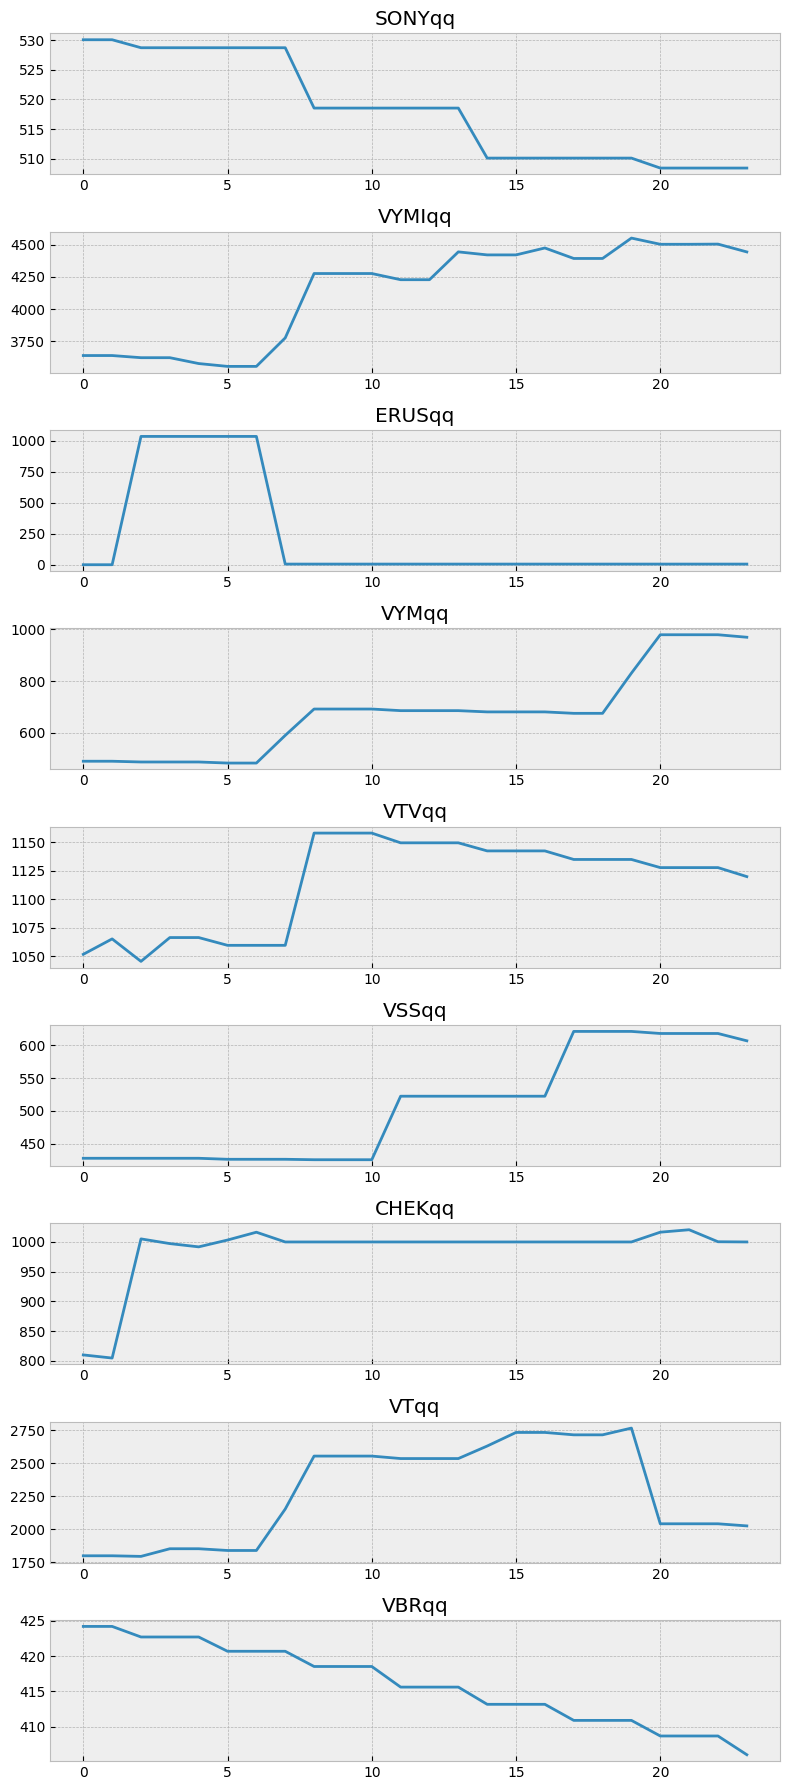

In [ ]:
subplotting_dataframe(quantity)

In [ ]:
adf_test(quantity)

Stationarity check for SONYqq
The series is not stationary based on ADF test
The series is not stationary based on KPSS test

Stationarity check for VYMIqq
The series is stationary based on ADF test
The series is not stationary based on KPSS test

Stationarity check for ERUSqq
The series is not stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for VYMqq
The series is not stationary based on ADF test
The series is not stationary based on KPSS test

Stationarity check for VTVqq
The series is not stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for VSSqq
The series is not stationary based on ADF test
The series is not stationary based on KPSS test

Stationarity check for CHEKqq
The series is stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for VTqq
The series is not stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check fo

/home/vincenzopi/Scrivania/MrRipStrategyAnalysis_venv/MrRipStrategyAnalysis_venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


# Detecting purchasing strategy: focusing on the amount bought each month of the same asset using a time-series approach
Given:
* a set of asset $A_{n}$,
* their quantity bought each month $Quantity_{A, t}$,

For each asset $A$, using time-series analysis, discovering any statistically significant association between $Quantity_{A, t}$ at any given time and $Quantity_{A, t-n}$

Interestingly enough, the couples
* VT - VYM
* CHECK - ERUS
* VBR - SONY
* VYMI - VSS 

show some visual similarities. However, correlation among different asset will be assessed in a different section

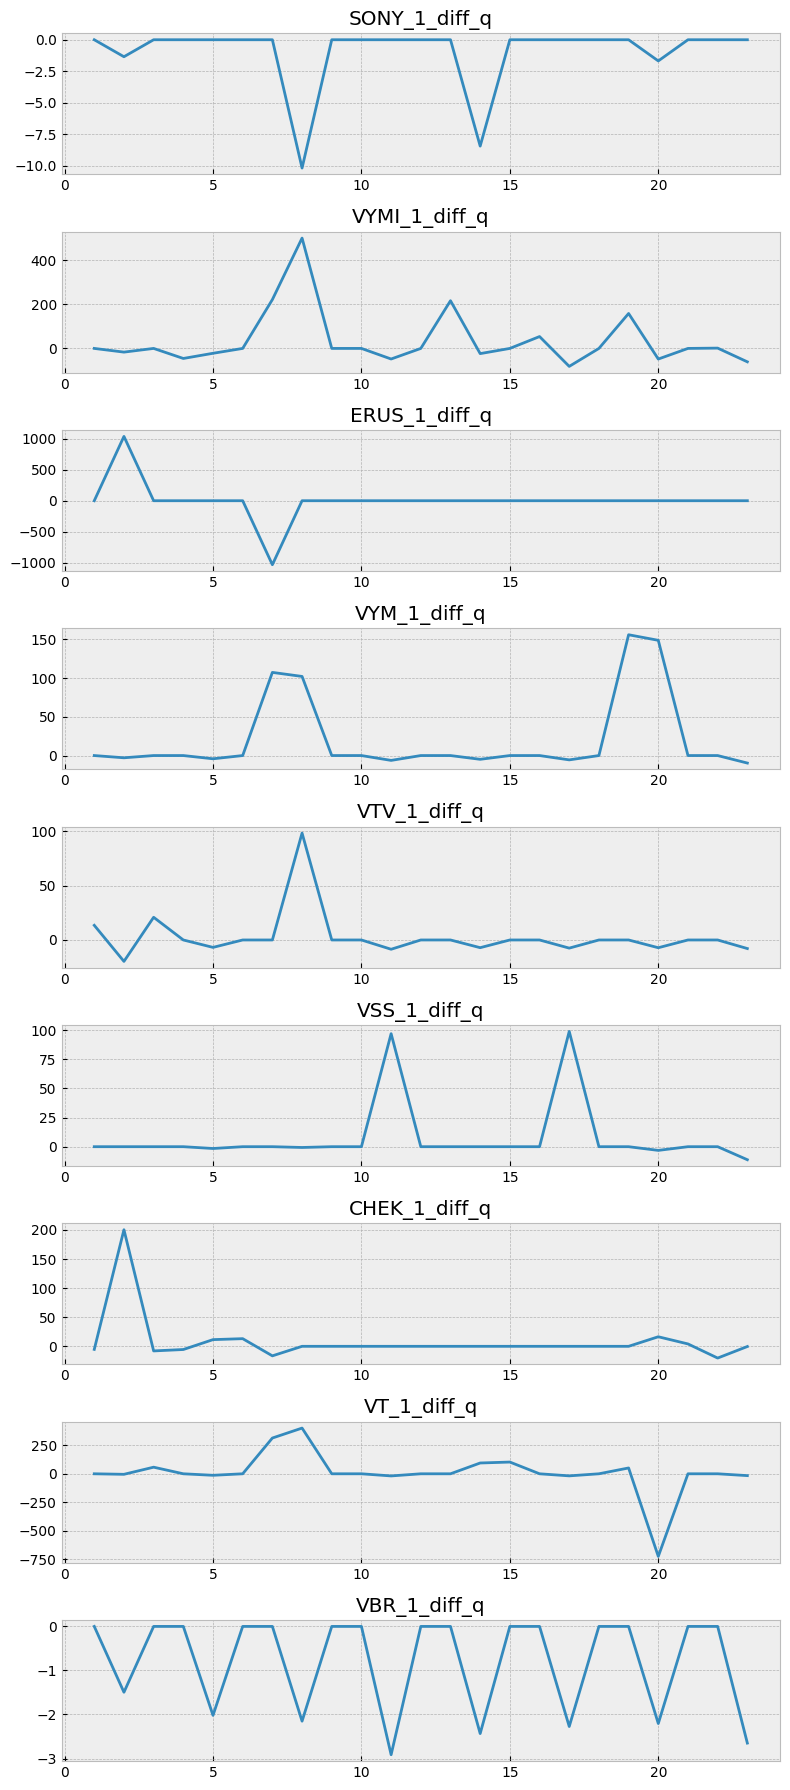

In [ ]:
subplotting_dataframe(quantity_change)

In [ ]:
adf_test(quantity_change.dropna())

Stationarity check for SONY_1_diff_q
The series is not stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for VYMI_1_diff_q
The series is stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for ERUS_1_diff_q
The series is stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for VYM_1_diff_q
The series is stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for VTV_1_diff_q
The series is not stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for VSS_1_diff_q
The series is not stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for CHEK_1_diff_q
The series is stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for VT_1_diff_q
The series is stationary based on ADF test
The series is stationary based on KPSS

/home/vincenzopi/Scrivania/MrRipStrategyAnalysis_venv/MrRipStrategyAnalysis_venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Plotting Time Series, ACF and PACF

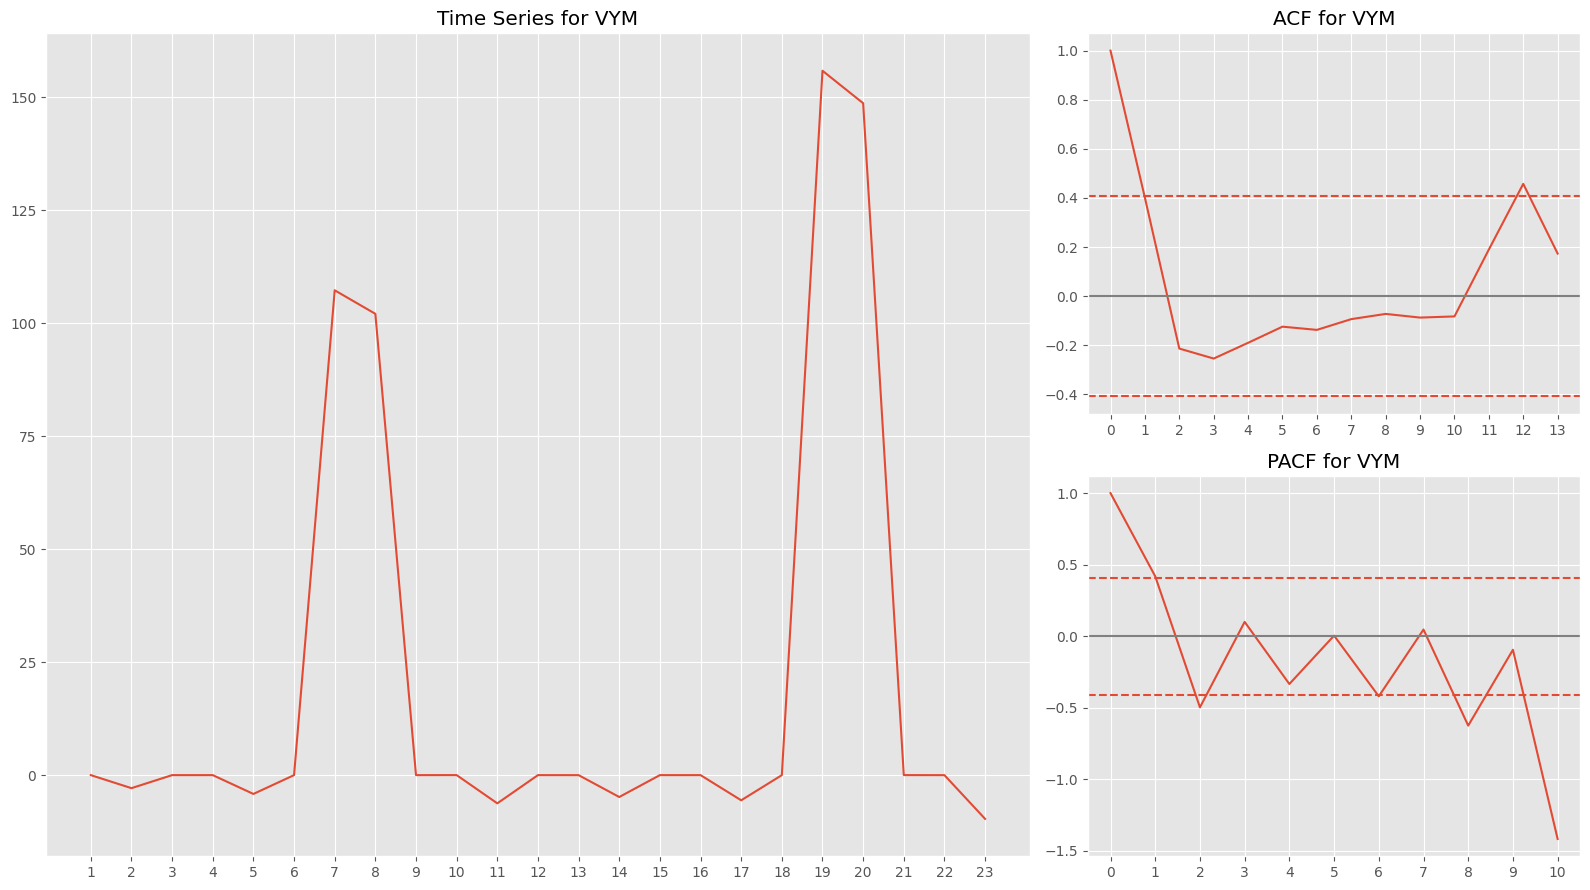

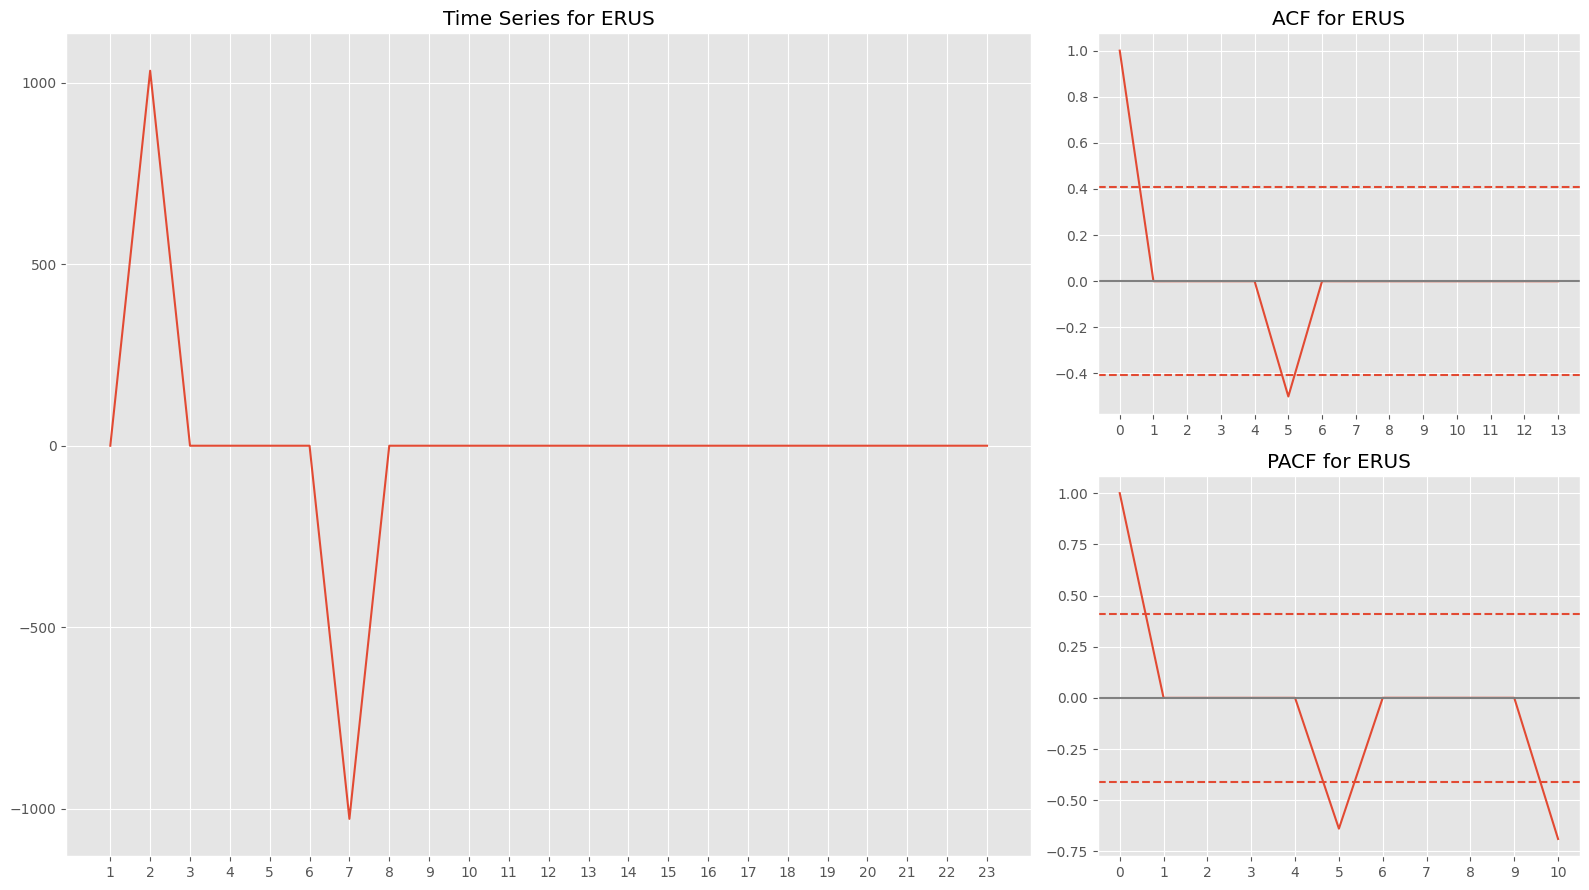

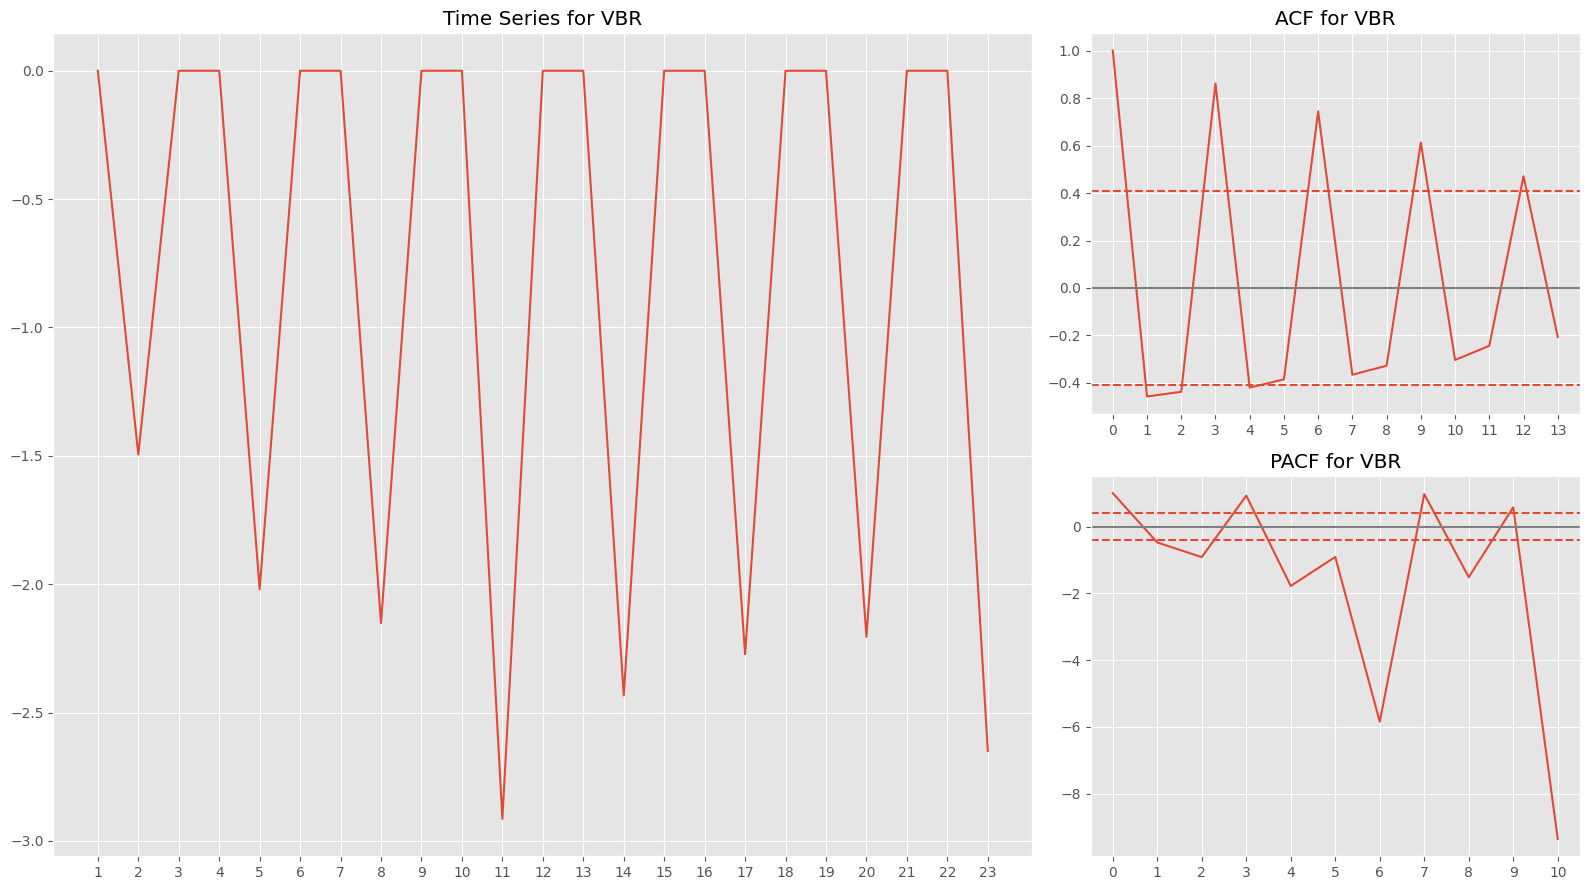

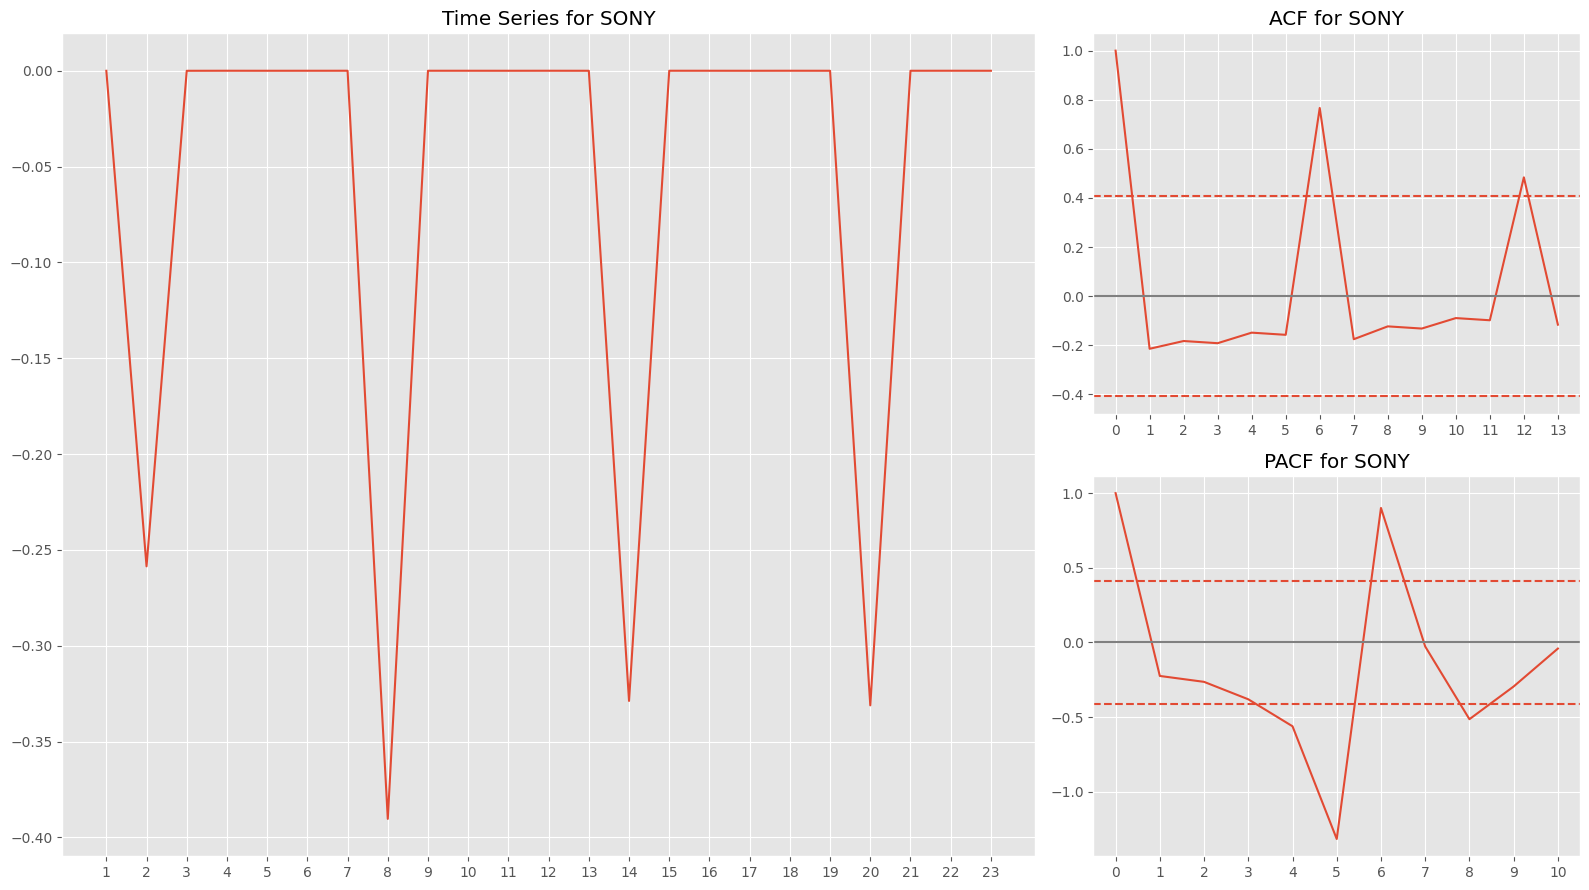

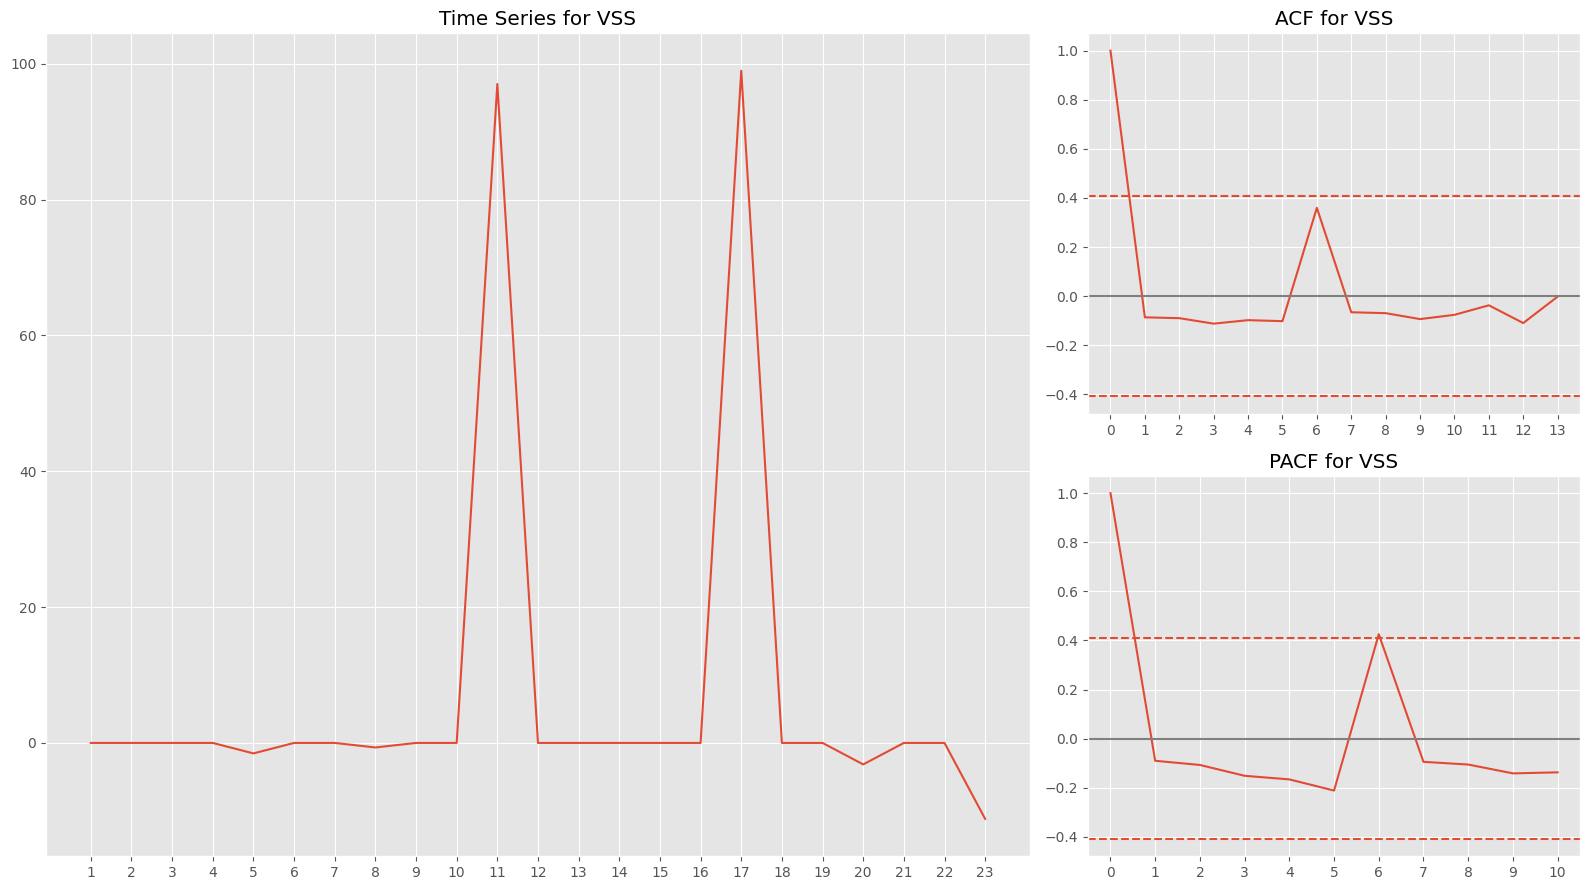

In [ ]:
def plotting(function):
    x_values = np.arange(0, len(function))
    plt.plot(x_values, function)
    plt.axhline(0, color='grey')
    plt.axhline(confidence_interval, linestyle='dashed')
    plt.axhline(-confidence_interval, linestyle='dashed')
    plt.xticks(x_values)

for column in amount_data.columns:
    # For each amount of asset bought and sold, calculate the auto correlation and partial autocorrelation functions
    acf_values = acf(amount_data[column])
    pacf_values = pacf(amount_data[column])

    # Define a confidence interval
    confidence_interval = 1.96 / np.sqrt(len(amount_data[column]))
    
    # If any of ACF-PACF value exceed the confidence interval excluding the first one - which is always statistically significant - , display the time series, the ACF and PACF
    if any(np.abs(acf_values[1:]) > confidence_interval) or any(np.abs(pacf_values[1:]) > confidence_interval):
        
        fig = plt.figure(figsize=(16, 9))
        gs = fig.add_gridspec(2, 2, width_ratios=[2, 1])

        # Time series plot spanning two rows
        ax0 = fig.add_subplot(gs[:, 0]) 
        ax0.plot(amount_data[column])
        ax0.set_title(f"Time Series for {column}")
        x_values_original = np.arange(1, len(amount_data[column]) + 1)
        ax0.set_xticks(x_values_original)

        # ACF plot
        ax1 = fig.add_subplot(gs[0, 1])
        plt.sca(ax1)
        plotting(acf_values)
        plt.title(f"ACF for {column}")

        # PACF plot
        ax2 = fig.add_subplot(gs[1, 1])
        plt.sca(ax2)
        plotting(pacf_values)
        plt.title(f"PACF for {column}")

        plt.tight_layout()
        plt.show()

Time lags where ACF or PACF exceeds confidence intervals will be the starting point for parameters selection MA and AR models, respectively.
At time lag 0, ACF and PACF always indicate strong association between any given time lag, and itself. Given that, ACF and PACF at time lag 0 will not be considered.

### Testing, fourier and SARIMA

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from scipy.fft import fft, fftfreq

<Axes: >

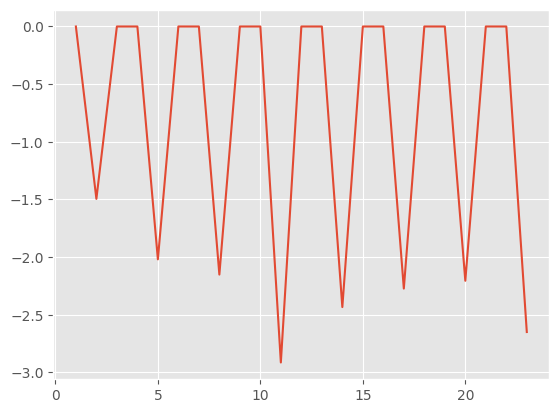

In [ ]:
data = amount_data["VBR"]
data.plot()

In [ ]:
data

1    -0.000005
2    -1.494895
3     0.000028
4    -0.000029
5    -2.019398
6     0.000128
7    -0.000129
8    -2.151471
9    -0.000045
10    0.000012
11   -2.913871
12   -0.000091
13   -0.000036
14   -2.433334
15   -0.000081
16   -0.000004
17   -2.272892
18    0.000031
19   -0.000041
20   -2.205292
21    0.000083
22   -0.000014
23   -2.649706
Name: VBR, dtype: float64

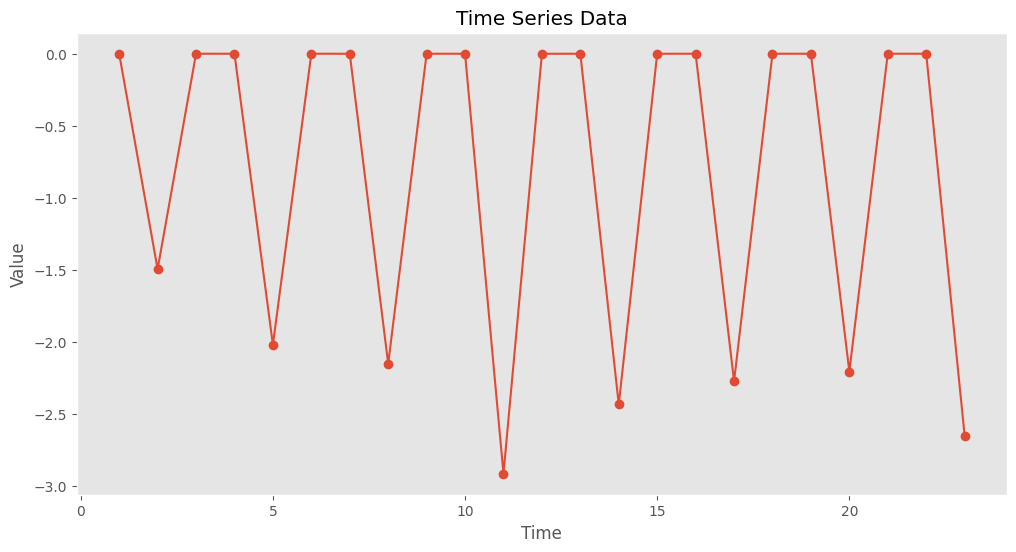

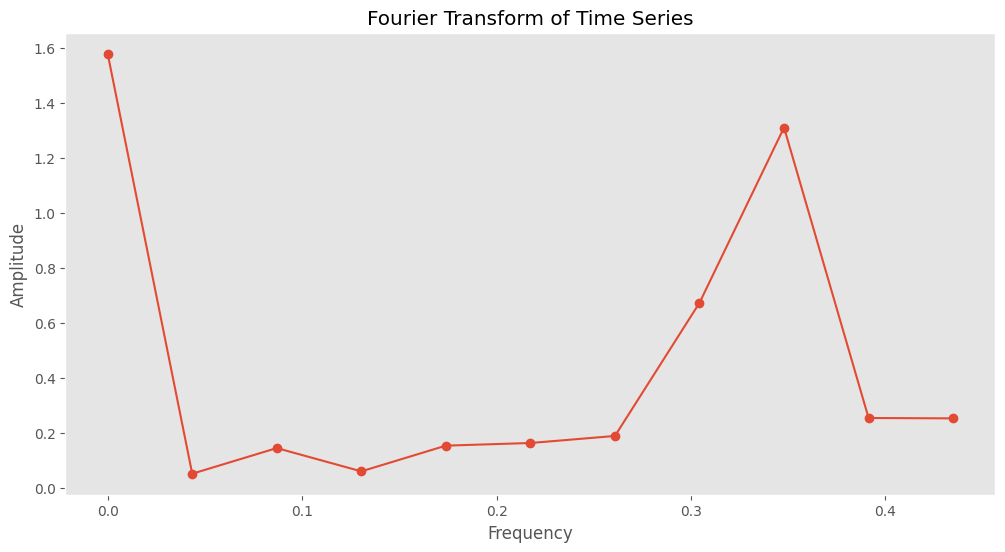

In [ ]:
data = {
    'time': np.arange(1, 24),
    'value': [
        -0.000005, -1.494895, 0.000028, -0.000029, -2.019398,
        0.000128, -0.000129, -2.151471, -0.000045, 0.000012,
        -2.913871, -0.000091, -0.000036, -2.433334, -0.000081,
        -0.000004, -2.272892, 0.000031, -0.000041, -2.205292,
        0.000083, -0.000014, -2.649706
    ]
}

df = pd.DataFrame(data)

plt.plot(df['time'], df['value'])
plt.title('Time Series Data')
plt.grid()
plt.show()


n = len(df['value'])
yf = fft(df['value'])
xf = fftfreq(n, 1)[:n//2]  # Only positive frequencies


plt.plot(xf, 2.0/n * np.abs(yf[:n//2])
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

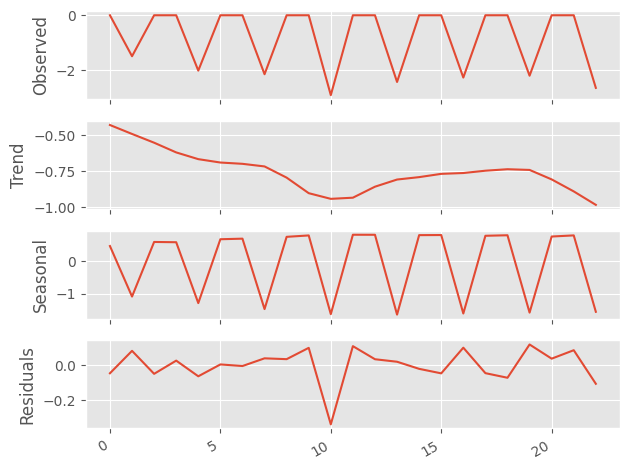

In [ ]:
# Decomposition

advanced_decomposition = STL(data['Value'], period = 3).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
ARIMA_model = auto_arima(amount_data['VBR'], error_action='ignore', trace=True, suppress_warnings=True, seasonal=True, m = 4)
ARIMA_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=24.627, Time=3.05 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=94.127, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=87.467, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=92.217, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=22.996, Time=2.06 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=21.013, Time=0.60 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=23.644, Time=0.68 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[4] intercept   : AIC=19.029, Time=0.14 sec
 ARIMA(2,1,1)(1,0,0)[4] intercept   : AIC=21.008, Time=0.18 sec
 ARIMA(2,1,1)(0,0,1)[4] intercept   : AIC=21.007, Time=0.32 sec
 ARIMA(2,1,1)(1,0,1)[4] intercept   : AIC=23.007, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[4] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(3,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   23
Model:               SARIMAX(2, 1, 1)   Log Likelihood                  -5.054
Date:                Tue, 08 Oct 2024   AIC                             18.108
Time:                        16:24:35   BIC                             22.472
Sample:                             0   HQIC                            19.136
                                 - 23                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9929      0.510     -1.948      0.051      -1.992       0.006
ar.L2         -0.9860      0.042    -23.317      0.000      -1.069      -0.903
ma.L1          0.0034      3.085      0.001      0.999      -6.043       6.050
sigma2         0.0661      0.016      4.147      0.000       0.035       0.097
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                10.36
Prob(Q):                              0.73   Prob(JB):                         0.01
Heteroskedasticity (H):               0.63   Skew:                            -1.31
Prob(H) (two-sided):                  0.56   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

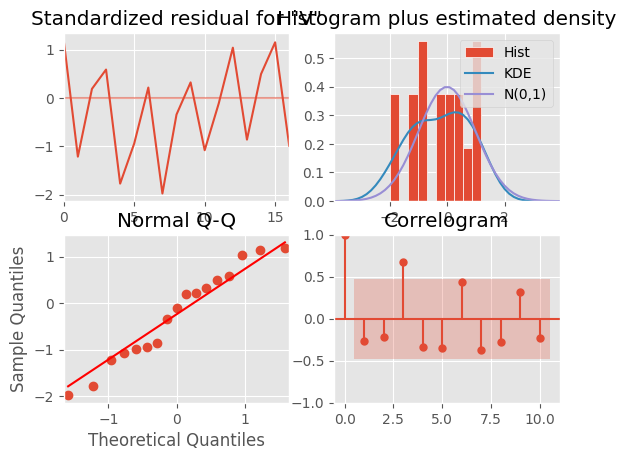

In [ ]:
results.plot_diagnostics();
residuals = results.resid

In [ ]:
acorr_ljungbox(residuals, np.arange(1, 2, 1))

,lb_stat,lb_pvalue
1,2.786434,0.095066


/home/vincenzopi/Scrivania/MrRipStrategyAnalysis_venv/MrRipStrategyAnalysis_venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vincenzopi/Scrivania/MrRipStrategyAnalysis_venv/MrRipStrategyAnalysis_venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vincenzopi/Scrivania/MrRipStrategyAnalysis_venv/MrRipStrategyAnalysis_venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoreg

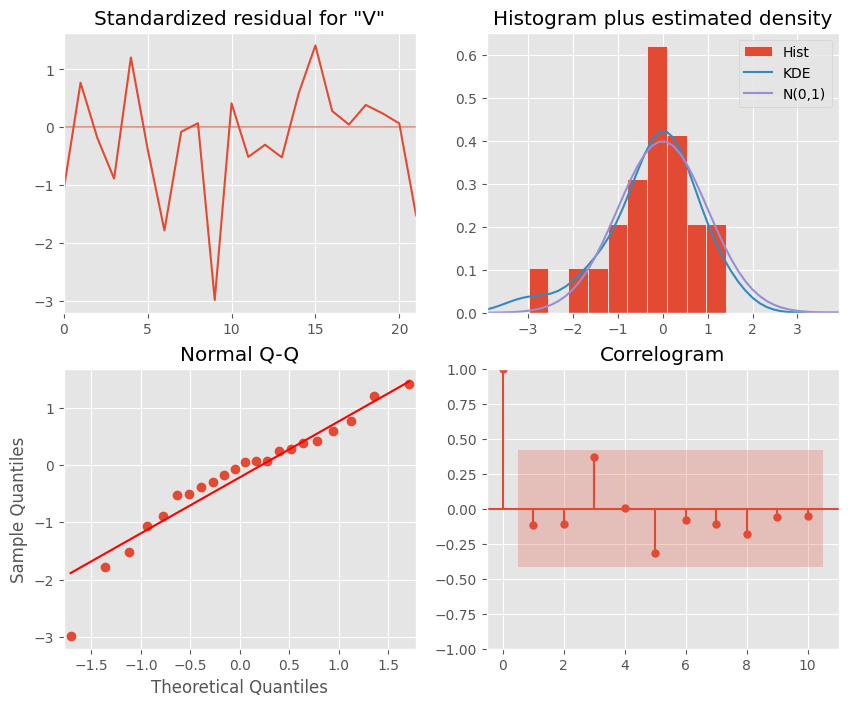

In [ ]:
SARIMA_model = SARIMAX(amount_data["VBR"], order=(1,1,1), seasonal_order=(2,0,1,2))
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [ ]:
residuals = SARIMA_model_fit.resid

In [ ]:
residuals

1    -0.000005
2    -1.494890
3     1.013928
4    -0.182857
5    -0.850352
6     0.527413
7    -0.115258
8    -0.538436
9    -0.023263
10    0.021107
11   -0.898594
12    0.124780
13   -0.154168
14   -0.090885
15   -0.156545
16    0.175686
17    0.425693
18    0.084423
19    0.014016
20    0.116046
21    0.072474
22    0.019989
23   -0.457959
dtype: float64

In [ ]:
acorr_ljungbox(residuals, np.arange(1, 2, 1))

,lb_stat,lb_pvalue
1,3.996524,0.045594
